# Projet P7 OC Data Scientist: Implémentez un modèle de scoring 

# 1. Problématique

De nombreuses personnes ont du mal à obtenir des prêts en raison d'historiques de crédit insuffisants ou inexistants. Et, malheureusement, cette population est souvent la cible de prêteurs peu fiables.

Des entreprises comme Home Credit s'efforcent d'élargir l'inclusion financière de la population non bancarisée en offrant une expérience d'emprunt positive et sûre. Afin de s'assurer que cette population mal desservie ait une expérience de prêt positive, Home Credit utilise une variété de données alternatives (par exemple, les informations sur les télécommunications et les transactions, données comportementales) pour prédire les capacités de remboursement de leurs clients.

L'objectif de ce projet est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera ou non en mesure de rembourser un prêt. Il s'agit d'une tâche de classification supervisée standard :

- **Supervisé** : les étiquettes sont incluses dans les données d'apprentissage et l'objectif est d'entraîner un modèle pour apprendre à prédire les étiquettes à partir des caractéristiques

- **Classification** : L'étiquette est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt)

Dans ce projet, les objectifs sont :
- la mise en oeuvre de routines d'exploration de données pour effectuer une analyse statistique et une visualisation.
- la mise en oeuvre de modèles de classification tels que Naïve Bayes, Logistic Regression, Support Vector Machine (SVM), Decision Tree, Random Forest, Gradient Boosting Machine (GBM) pour prédire si un demandeur pourra ou non rembourser un prêt.
- l'évaluation des modèles de classification (analyse de la précision, de la matrice de confusion, du rappel, du taux de vrai négatif (TNR), du taux de fausse découverte (FDR), affichage du graphique de gain, du graphique de levage, du graphique KS, du graphique ROC – AUC).
- le déploiement de la solution finale en tant qu'application Web (API Restful).

# 2. Environnement et importation des librairies

In [1]:
# Librairies communes
from IPython.core.display import display, HTML
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.stats import uniform
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly
import pickle
import joblib
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances
from collections import Counter
from scipy.stats import loguniform
import shap

# Librairies pour l'affichage
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Librairies diverses
import os
import gc
import pickle
import warnings
warnings.filterwarnings(action='ignore')
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# For 100% jupyter notebook cell width
from IPython.core.display import display, HTML

# Librairies Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from yellowbrick.classifier import DiscriminationThreshold

# Librairie fonctions pour le projet
# Import du kernel Kaggle pour la préparation ded données
# Ancien kernel Kaggle
#from p7_preprocess_data_eda_kernel_kaggle import *

# Nouveau kernel Kaggle
from p7_data_preparation_kernel_kaggle import *
from p7_eda_kernel_kaggle import *

# Fonctions pour le projet P7
from p7_functions import *

# Pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

# Versions des librairies
print("Version librairie pandas: " + pd.__version__)
print("Version librairie numpy: " + np.__version__)
print("Version librairie matplotlib: " + matplotlib.__version__)
print("Version librairie seaborn: " + sns.__version__)
print("Version librairie imblearn: " + imblearn.__version__)

Version librairie pandas: 1.3.0
Version librairie numpy: 1.19.5
Version librairie matplotlib: 3.3.2
Version librairie seaborn: 0.11.0
Version librairie imblearn: 0.8.1


# 3. Fonctions

In [2]:
# Affichage des informations sur un dataset
def display_dataset_general_info(df_in, df_in_desc, info_suppl, id_df_in_merge_pk,
                                 id_df_in_merge_fk, df_in_application_train, df_in_application_test):
    print('Dimensions du dataset ' + df_in_desc +  ' est: ' + str(df_in.shape))
    print('-'*100)
    if info_suppl != None:
        print('Nombre d\'identifiants uniques ' + id_df_in_merge_pk + ' dans ' + df_in_desc 
              + ': ' +  str(len(df_in[id_df_in_merge_pk].unique())))
        print('Nombre d\'identifiants clés étrangères ' + id_df_in_merge_fk + ' dans ' + df_in_desc 
              + ': ' +  str(len(df_in[id_df_in_merge_fk].unique())))
        print('Nombre de correspondances ' + id_df_in_merge_fk 
              + ' entre dataset application_train et ' + df_in_desc + ': ' +
              str(len(set(df_in_application_train[id_df_in_merge_fk].unique()).intersection(set(df_in[id_df_in_merge_fk].unique())))))
        print('Nombre de correspondances ' + id_df_in_merge_fk 
              + ' entre dataset application_test et ' + df_in_desc + ': ' +
              str(len(set(df_in_application_test[id_df_in_merge_fk].unique()).intersection(set(df_in[id_df_in_merge_fk].unique())))))
        print('-'*100)
        
    print('Nombre de valeurs dupliquées dans ' +  df_in_desc + ': ' +  str(df_in.shape[0] - df_in.duplicated().shape[0]))
    print('-'*100)
    display(df_in.head())

In [3]:
# Fonction pour supprimer les colonnes d'un dataset 35 % ou plus de valeurs NaN
def drop_column_perc_nan(df_in, perc_nan):
    mod_df_in = df_in.copy()
    min_count =  int(((100-perc_nan)/100)*mod_df_in.shape[0] + 1)
    mod_df_in.dropna( axis=1, thresh=min_count, inplace=True)
    
    return mod_df_in

In [4]:
# Fonction pour standardisation des données du dataset
def std_dataset(df_in, method_std):
    df_in_std = pd.DataFrame(method_std.fit_transform(df_in), columns = df_in.columns)
    
    return df_in_std

In [5]:
# Fonction pour optimiser valeur k de KNN
def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 2):
        print("k: " + str(k))
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LogisticRegression()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        print(errors)
        
    return errors

In [6]:
# Fonction pour imputation KNN
def imputation_nan_knn(df_in, k):
    imputer = KNNImputer(n_neighbors=k)
    imputed = imputer.fit_transform(df_in)
    df_imputed = pd.DataFrame(imputed, columns=df.columns)
    
    return df_imputed

In [7]:
# Fonction pour modelisation simple baseline
def model_baseline(model, model_name, X_train, y_train, X_test, y_test, 
                   df_save_metrics, cost_function_flag, tnrw, tprw, fpcw, fncw, 
                   class_weight_flag):
    # Entraînement du modèle sur le dataset train
    model.fit(X_train, y_train)

    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    # Métriques    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("AUC score: ", str(auc))
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred)
    
    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    if class_weight_flag != None:
        class_weight = "Class weights"
    else:
        class_weight = "N/A"
    
    if cost_function_flag != None:
        # Calcul de la fonction de coût personnalisée
        ccf, ocf = eval_custom_metric(cm, tnrw, tprw, fpcw, fncw)
    
        # Enregistrement des résultats des métriques
        df_results = save_results_metrics(df_save_metrics, model_name, class_weight, 
                                      "N/A", accuracy, auc,
                                      round(ccf,0), round(ocf,0), round(ccf/ocf,4), 
                                      metrics_by_class)
    else:
        # Enregistrement des résultats des métriques
        df_results = save_results_metrics(df_save_metrics, model_name, class_weight, 
                                      "N/A", accuracy, auc,
                                      "N/A", "N/A", "N/A", 
                                      metrics_by_class)
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
          
    return cm, classif_report, df_results      

In [8]:
# Fonction pour affichage matrice de confusion
def display_matrix_confusion(confusion_matrix):
    
    labels = ['True Neg','False Pos','False Neg','True Pos'] 
    categories = ['0 - Non Defaulter', '1 - Defaulter'] 
    make_confusion_matrix(confusion_matrix, 
                      group_names=labels, 
                      categories=categories, 
                      cmap='Blues',
                      cbar=False,
                      sum_stats=False,
                      figsize=(4,4))
    
    return None

In [9]:
# Fonction pour l'enregistrement des résultats des métriques des classifieurs
def save_results_metrics(df_in, model, method_imb, optim_param, acc, 
                         auc, cost_function, optimum_cost_function, 
                         ratio_custom_optim_cost, 
                         metrics_class):
    # Tableau vide
    if df_in.shape[0] == 0:
        df_in.loc[0]=[model, method_imb, optim_param, acc,
                      auc, 
                      cost_function, optimum_cost_function, 
                      ratio_custom_optim_cost, 
                      metrics_class[0][0], metrics_class[0][1],
                      metrics_class[1][0], metrics_class[1][1],
                      metrics_class[2][0], metrics_class[2][1]]
        
    # Tableau non vide
    else:    
        df_in.loc[df_in.shape[0]]=[model, method_imb, optim_param, acc, 
                                   auc, 
                                   cost_function, optimum_cost_function,
                                   ratio_custom_optim_cost,
                                   metrics_class[0][0], metrics_class[0][1],
                                   metrics_class[1][0], metrics_class[1][1],
                                   metrics_class[2][0], metrics_class[2][1]]
        
    return df_in

In [10]:
# Fonction pour calculer métrique personnalisée - fonction de coût
def eval_custom_metric(confusion_matrix, tnrw, tprw, fpcw, fncw):
    tn = confusion_matrix[0][0]
    fp = confusion_matrix[0][1]
    fn = confusion_matrix[1][0]
    tp = confusion_matrix[1][1]
    
    # Fonction de coût / revenu net
    revenue_net = tn*tnrw + tp*tprw + fn*fncw + fp*fpcw
    
    # Fonction de coût / revenu net idéale 
    # avec des prédictions de classes sans erreur
    
    revenue_net_optim = (tn+fp)*tnrw + (tp+fn)*tprw
    
    return revenue_net, revenue_net_optim

In [11]:
# Fonction pour modelisation classifier baseline avec LogisticRegression
# Détermination de la méthode de traitement de déséquilibrage des classes
def eval_imbalance_class_method(over_sample, under_sample, class_weight,
                                X_train, y_train, X_test, y_test, df_save_metrics,
                                tnrw, tprw, fprw, fncw, method_imb_name):
    
    # Nombre individus par classe sur y_train
    print("Nombre individus par classe sur y_train:")
    print(Counter(y_train))
    
    # Instanciation du modèle LogisticRegression
    model = LogisticRegression()
    
    # Détermination des étapes du pipeline imblearn
    if over_sample == None and under_sample == None and class_weight == None:
        print("Il faut passer un méthode over ou undersempling ou class weight")
        return None
    
    elif (over_sample != None and under_sample == None):
        print("Méthode de sur-échantillonnage: " + method_imb_name)
        # Pipeline imblearn
        steps = [('mth_imb', over_sample)]
            
    elif (over_sample == None and under_sample != None):
        print("Méthode de sous-échantillonnage: " + method_imb_name)
        # Pipeline imblearn
        steps = [('mth_imb', under_sample)]
        
    else:
        print("Cas non géré")
        return None
    
    pipeline = Pipeline(steps=steps)
    
    # Rééchantillonnage des classes déséquilibrées
    X_train_imb, y_train_imb = pipeline.fit_resample(X_train, y_train)
        
    # Nombre individus par classe sur y_train_imb
    print("Nombre individus par classe sur y_train_imb après rééquilibrage des classes:")
    print(Counter(y_train_imb))

    # Entraînement du modèle sur le dataset train
    model.fit(X_train_imb, y_train_imb)

    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    # Métriques    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("AUC score: ", str(auc))
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred)
    
    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    # Calcul de la fonction de coût personnalisée
    ccf, ocf = eval_custom_metric(cm, tnrw, tprw, fpcw, fncw)
    
    # Enregistrement des résultats des métriques
    df_results = save_results_metrics(df_save_metrics, "LogisticRegression",
                                      method_imb_name, "N/A",
                                      accuracy, auc,
                                      ccf, ocf, round(ccf/ocf,4), metrics_by_class)
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
          
    return cm, classif_report, df_results, X_train_imb, y_train_imb

In [12]:
def optim_hyperparam_model(X_train, X_test, y_train, y_test, model, 
                                   param_grid, model_txt, nb_fold):

    print('Optimisation des hyper-paramètres pour le modèle ' + model_txt)
    print('---------------------------------------------------------------------------------')
    print('')
    
    # Date de début de traitement
    start = datetime.now()
    
    model_grid = GridSearchCV(estimator=model, 
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv=nb_fold,
                      verbose=2,
                      n_jobs=1,       
                     )
    
    # Entraînement du modèle
    model_grid.fit(X_train, y_train)
    
    print("best score: ", model_grid.best_score_)
    print("best param: ", model_grid.best_params_)
    
    # Sauvegarde des hyper-paramètres optimisés
    joblib.dump(model_grid.best_params_,
                './input/'+model_txt+'_'+'optim_params.pkl')
    
    # Durée du traitement
    print(f'Durée traitement optimisation hyper-paramètres = {datetime.now() - start}')
    
    return None

In [13]:
# Fonction pour la prédiction des valeurs cible
def predict_model(X_train, y_train, X_test, y_test, model, model_txt,
                  fic_hyperparam, tnrw, tprw, fpcw, fncw, df_save_metrics, 
                  threshold, method_imb_name):
    
    # Chargement du fichier des hyper-paramètres
    loaded_hyp_param = joblib.load(fic_hyperparam)
    print('-----------------------------------------------------------------------------')
    print('Entraînement du modèle sur les hyper-paramètres optimisés: ' + model_txt)
    print('-----------------------------------------------------------------------------')
    print('Chargement du fichier des hyper-paramètres: ' + fic_hyperparam) 
    print('Hyper-paramètres optimisés: ' + str(loaded_hyp_param))
    
    
    model.set_params(**loaded_hyp_param)
    print('Prédictions avec les paramètres suivants du modèle:')
    print(model.get_params())
    print('')
    
    # Entraînement du modèle sur le dataset train
    model.fit(X_train, y_train)
   
    # Prédictions sur le train et test set
    if threshold == None:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    elif threshold >= 0 and threshold <=1:
        y_pred_train = model.predict_proba(X_train)
        y_pred_test = model.predict_proba(X_test)
        
        y_pred_train = (y_pred_train[::,1] > threshold )*1
        y_pred_test = (y_pred_test[::,1] > threshold )*1
    else:
        print('Valeur de seuil non gérée')

    
    # Métriques    
    # AUC
    auc_train = metrics.roc_auc_score(y_train, y_pred_train)
    auc_test = metrics.roc_auc_score(y_test, y_pred_test)
    print("AUC score train: ", str(auc_train))
    print("AUC score test: ", str(auc_test))
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred_test)
    
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred_test)
    
    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Calcul de la fonction de coût personnalisée
    ccf, ocf = eval_custom_metric(cm, tnrw, tprw, fpcw, fncw)
    
    # Enregistrement des résultats des métriques
    df_results = save_results_metrics(df_save_metrics, model_txt,
                                      method_imb_name, loaded_hyp_param,
                                      accuracy, auc_test,
                                      ccf, ocf, round(ccf/ocf,4), metrics_by_class)
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred_test) 
    
    return cm, classif_report, df_results

In [14]:
# Fonction pour afficher le seuil de discrimination
def display_seuil_discrimination(model, X_train, y_train, X_test, y_test):
    viz = DiscriminationThreshold(model,
                                  cv=0.2,
                                  fig=plt.figure(figsize=(9,6)))

    viz.fit(X_train, y_train)

    #viz.score(X_test, y_test)

    viz.show()
    
    return None

In [15]:
def plot_feature_importance(df, col_x, col_y, title, x_label, y_label):
    plt.figure(figsize=(4, 4))
    sns.boxplot(x=col_x,
                y=col_y, 
                data=df, 
               showmeans=True,
               showfliers=False,
               meanprops={"marker":"o",
                          "markerfacecolor":"red", 
                          "markeredgecolor":"red",
                          "markersize":"7"})
    plt.ylabel(y_label, size=14)
    plt.xlabel(x_label, size=14)
    plt.title(title, size=14)
    
    return None

# 4. Chargement des données pour dasboard

In [16]:
# Chargement des données pour prédictions
# Données standardisées pour classification
data_predict = pd.read_csv('./Input/dataset_final/train_data_mod_tr_nan_std_id.csv',\
                           sep=",")

In [17]:
# Prise en compte de 10000 clients
data_predict_api = data_predict.iloc[:10000, :]

In [18]:
data_predict_api.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL

In [19]:
data_predict_api.to_csv('./Input/data_predict_api.csv', index=False)

In [20]:
# Chargement des données dataset dashboard (sans standardisation)
data_api = pd.read_csv('./Input/dataset_final/train_data_mod_tr_nan_id.csv', sep=",")

In [21]:
data_api.shape

(307507, 334)

In [22]:
data_api.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL

In [23]:
# Chargement des données dasboard (target)
data_api_target = pd.read_csv('./Input/dataset_final/train_data_target.csv', sep=",")

In [24]:
data_api_target.head(3)

,TARGET
0,1
1,0
2,0


In [25]:
data_api_with_target = pd.concat([data_api, data_api_target[['TARGET']]], axis=1)

In [26]:
data_api_with_target.shape

(307507, 335)

In [27]:
data_api_with_target.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL

In [28]:
data_api_with_target.to_csv('./Input/data_api_target.csv', index=False)

# 5. Création des tableaux sur le client et groupe de clients

In [29]:
feature_important_data = ['SK_ID_CURR',
                          'CODE_GENDER',
                          'ANNUITY_CREDIT_PERCENT_INCOME',
                          'AMT_ANNUITY',
                          'AMT_INCOME_TOTAL',
                          'AGE',
                          'DAYS_EMPLOYED_PERCENT',
                          'CREDIT_REFUND_TIME']

feature_important_data_target = ['SK_ID_CURR',
                                 'CODE_GENDER',
                                 'ANNUITY_CREDIT_PERCENT_INCOME',
                                 'AMT_ANNUITY',
                                 'AMT_INCOME_TOTAL',
                                 'AGE',
                                 'DAYS_EMPLOYED_PERCENT',
                                 'CREDIT_REFUND_TIME',
                                 'TARGET']

In [30]:
data_api_with_target[feature_important_data_target].head()

,SK_ID_CURR,CODE_GENDER,ANNUITY_CREDIT_PERCENT_INCOME,AMT_ANNUITY,AMT_INCOME_TOTAL,AGE,DAYS_EMPLOYED_PERCENT,CREDIT_REFUND_TIME,TARGET
0,100002,0.00,0.12,24700.50,202500.00,26.00,0.07,16.46,1
1,100003,1.00,0.13,35698.50,270000.00,46.00,0.07,36.23,0
2,100004,0.00,0.10,6750.00,67500.00,52.00,0.01,20.00,0
3,100006,1.00,0.22,29686.50,135000.00,52.00,0.16,10.53,0
4,100007,0.00,0.18,21865.50,121500.00,55.00,0.15,23.46,0


In [109]:
data_feat = data_api_with_target[feature_important_data_target]

In [110]:
data_feat.head()

,SK_ID_CURR,CODE_GENDER,ANNUITY_CREDIT_PERCENT_INCOME,AMT_ANNUITY,AMT_INCOME_TOTAL,AGE,DAYS_EMPLOYED_PERCENT,CREDIT_REFUND_TIME,TARGET
0,100002,0.00,0.12,24700.50,202500.00,26.00,0.07,16.46,1
1,100003,1.00,0.13,35698.50,270000.00,46.00,0.07,36.23,0
2,100004,0.00,0.10,6750.00,67500.00,52.00,0.01,20.00,0
3,100006,1.00,0.22,29686.50,135000.00,52.00,0.16,10.53,0
4,100007,0.00,0.18,21865.50,121500.00,55.00,0.15,23.46,0


In [111]:
df_interprete = data_feat.copy()

In [112]:
# Création des tableaux interprétables
df_interprete.rename(columns={
    'SK_ID_CURR': 'Id client',
    'CODE_GENDER': 'Genre (H/F)',
    'ANNUITY_CREDIT_PERCENT_INCOME': '% annuités/revenus',
    'AMT_ANNUITY': 'Annuités',
    'AMT_INCOME_TOTAL': 'Revenus globaux',
    'AGE': 'Age client (ans)',
    'DAYS_EMPLOYED_PERCENT': '% jours travaillés',
    'CREDIT_REFUND_TIME': 'Durée remb crédit (ans)',
    'TARGET' : 'Cible'
    }, inplace=True)


df_interprete['Genre (H/F)'] = np.where((df_interprete['Genre (H/F)'] == 1),'F','M')
df_interprete['% annuités/revenus'] = round(df_interprete['% annuités/revenus']*100,1)
df_interprete['Age client (ans)'] = df_interprete['Age client (ans)'].astype(int)
df_interprete['% jours travaillés'] = round(df_interprete['% jours travaillés']*100,1)
df_interprete['Durée remb crédit (ans)'] = round(df_interprete['Durée remb crédit (ans)'].astype(float),1)
df_interprete['Cible'] = df_interprete['Cible'].astype(str)
df_interprete['Cible'] = df_interprete['Cible'].replace(['0','1'],['Client non défaillant','Client défaillant'])

In [113]:
df_interprete.head()

,Id client,Genre (H/F),% annuités/revenus,Annuités,Revenus globaux,Age client (ans),% jours travaillés,Durée remb crédit (ans),Cible
0,100002,M,12.20,24700.50,202500.00,26,6.70,16.50,Client défaillant
1,100003,F,13.20,35698.50,270000.00,46,7.10,36.20,Client non défaillant
2,100004,M,10.00,6750.00,67500.00,52,1.20,20.00,Client non défaillant
3,100006,F,22.00,29686.50,135000.00,52,16.00,10.50,Client non défaillant
4,100007,M,18.00,21865.50,121500.00,55,15.20,23.50,Client non défaillant


In [102]:
df_interprete.shape

(307507, 9)

In [114]:
df_interprete.to_csv("./Input/df_interprete.csv", index=False)

# 6. Création modèle des plus proches voisins

In [68]:
from sklearn.neighbors import NearestNeighbors

data_api_with_target_10000 = data_api_with_target.iloc[:10000, :]

# définition du modèle des plus proches voisins
# on standardise
std = StandardScaler()
df_std = std.fit_transform(data_api_with_target_10000[feature_important_data])
df_std = pd.DataFrame(df_std,
                      index=data_api_with_target_10000.index,
                      columns=[feature_important_data])

nn = NearestNeighbors(n_neighbors=50)
nn.fit(df_std)

NearestNeighbors(n_neighbors=50)

In [64]:
df_std.head()

,SK_ID_CURR,CODE_GENDER,ANNUITY_CREDIT_PERCENT_INCOME,AMT_ANNUITY,AMT_INCOME_TOTAL,AGE,DAYS_EMPLOYED_PERCENT,CREDIT_REFUND_TIME
0,-1.74,-1.39,-0.62,-0.17,0.37,-1.51,-0.68,-0.67
1,-1.73,0.72,-0.51,0.60,1.09,0.18,-0.65,1.89
2,-1.73,-1.39,-0.85,-1.41,-1.06,0.68,-1.13,-0.21
3,-1.73,0.72,0.40,0.18,-0.34,0.68,0.08,-1.44
4,-1.73,-1.39,-0.02,-0.36,-0.49,0.93,0.01,0.23


In [65]:
client_list = std.transform(data_api_with_target_10000[feature_important_data])  # standardisation

for i in range(len(data_api_with_target_10000)):
    distance, voisins = nn.kneighbors([client_list[i]])
    voisins = voisins[0]
    # on crée un dataframe avec les voisins
    voisins_table = pd.DataFrame()
    for v in range(len(voisins)):
        voisins_table[v] = data_api_with_target_10000[feature_important_data].iloc[voisins[v]]
voisins_table.head()

KeyboardInterrupt: 

In [59]:
voisins_table

,0,1,2,3,4,5,6
SK_ID_CURR,111633.00,111092.00,111372.00,111056.00,110613.00,110160.00,110095.00
CODE_GENDER,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ANNUITY_CREDIT_PERCENT_INCOME,0.20,0.17,0.21,0.20,0.16,0.22,0.21
AMT_ANNUITY,18742.50,19120.50,24052.50,22941.00,17784.00,20182.50,18927.00
AMT_INCOME_TOTAL,94500.00,112500.00,112500.00,112500.00,112500.00,90000.00,90000.00
AGE,26.00,28.00,22.00,23.00,23.00,28.00,25.00
DAYS_EMPLOYED_PERCENT,0.04,0.07,0.03,0.05,0.06,0.08,0.04
CREDIT_REFUND_TIME,18.97,20.42,18.33,14.96,21.45,16.44,14.37


# 7. Export modèles

In [69]:
path = './Input/'
filename = path + 'NearestNeighborsModel.pkl'
outfile = open(filename,'wb')
pickle.dump(nn, outfile)
outfile.close()

In [67]:
filename =  path + 'StandardScaler.pkl'
outfile = open(filename,'wb')
pickle.dump(std, outfile)
outfile.close()

In [55]:
data_api_with_target_10000.to_csv(path + "df_nn.csv", index=False)

# 8. Création des radar plots

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


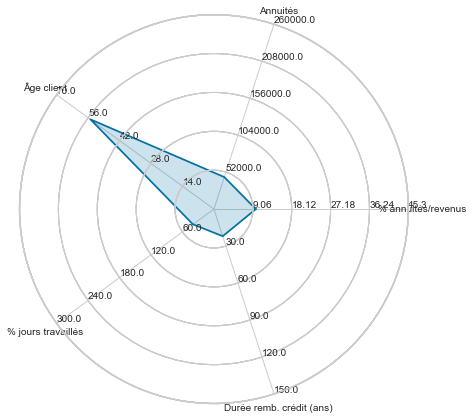

In [45]:
# Exemple
variables = ("% annuités/revenus", "Annuités", "Âge client", 
            "% jours travaillés", "Durée remb. crédit (ans)")
data_ex = (9.76, 45000, 55, 40, 22)
ranges = [(0.0, 45.3), (0, 260000), (0, 70),
         (0,300), (0, 150)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data_ex)
radar.fill(data_ex, alpha=0.2)
plt.show()    

# 9. Informations générales sur les clients du dataset

In [46]:
df_interprete['pl % annuités/revenus'] = ""

In [116]:
df_interprete['pl Age client (ans)'] = ""

In [48]:
for i in range(len(df_interprete)):
    if df_interprete['% annuités/revenus'].iloc[i]<20:
        df_interprete['pl % annuités/revenus'].iloc[i] = 'entre 0 et 20 %'
    elif df_interprete['% annuités/revenus'].iloc[i]<40:
        df_interprete['pl % annuités/revenus'].iloc[i] = 'entre 20 et 40 %'
    elif df_interprete['% annuités/revenus'].iloc[i]<60:
        df_interprete['pl % annuités/revenus'].iloc[i] = 'entre 40 et 60 %'
    elif df_interprete['% annuités/revenus'].iloc[i]<80:
        df_interprete['pl % annuités/revenus'].iloc[i] = 'entre 60 et 80 %'
    elif df_interprete['% annuités/revenus'].iloc[i]<100:
        df_interprete['pl % annuités/revenus'].iloc[i] = 'entre 80 et 100 %'
    else:
        df_interprete['pl % annuités/revenus'].iloc[i] = 'plus de 100 %'

In [118]:
for i in range(len(df_interprete)):
    if df_interprete['Age client (ans)'].iloc[i]<25:
        df_interprete['pl Age client (ans)'].iloc[i] = 'entre 18 et 25 ans'
    elif df_interprete['Age client (ans)'].iloc[i]<35:
        df_interprete['pl Age client (ans)'].iloc[i] = 'entre 25 et 35 ans'
    elif df_interprete['Age client (ans)'].iloc[i]<45:
        df_interprete['pl Age client (ans)'].iloc[i] = 'entre 35 et 45 ans'
    elif df_interprete['Age client (ans)'].iloc[i]<55:
        df_interprete['pl Age client (ans)'].iloc[i] = 'entre 45 et 55 ans'
    elif df_interprete['Age client (ans)'].iloc[i]<65:
        df_interprete['pl Age client (ans)'].iloc[i] = 'entre 55 et 65 ans'
    else:
        df_interprete['pl Age client (ans)'].iloc[i] = 'plus de 65 ans'

In [119]:
df_interprete.head()

,Id client,Genre (H/F),% annuités/revenus,Annuités,Revenus globaux,Age client (ans),% jours travaillés,Durée remb crédit (ans),Cible,pl Age client (ans)
0,100002,M,12.20,24700.50,202500.00,26,6.70,16.50,Client défaillant,entre 25 et 35 ans
1,100003,F,13.20,35698.50,270000.00,46,7.10,36.20,Client non défaillant,entre 45 et 55 ans
2,100004,M,10.00,6750.00,67500.00,52,1.20,20.00,Client non défaillant,entre 45 et 55 ans
3,100006,F,22.00,29686.50,135000.00,52,16.00,10.50,Client non défaillant,entre 45 et 55 ans
4,100007,M,18.00,21865.50,121500.00,55,15.20,23.50,Client non défaillant,entre 55 et 65 ans


In [50]:
import numpy as np
import pandas as pd
import plotly.express as px

df_g = df_interprete.groupby(['Genre (H/F)', 'Cible']).size().reset_index()
df_g['percentage'] = df_interprete.groupby(['Genre (H/F)', 'Cible']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
df_g.columns = ['Genre (H/F)', 'Cible', 'Counts', 'Percentage']

fig = px.bar(df_g, x='Genre (H/F)', y=['Counts'], color='Cible', text=df_g['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))
    
fig.update_layout(
    autosize=False,
    width=400,
    height=400)

fig.show()

In [51]:
import numpy as np
import pandas as pd
import plotly.express as px

df_g = df_interprete.groupby(['pl Age client (ans)', 'Cible']).size().reset_index()
df_g['percentage'] = df_interprete.groupby(['pl Age client (ans)', 'Cible']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
df_g.columns = ['pl Age client (ans)', 'Cible', 'Counts', 'Percentage']

fig = px.bar(df_g, x='pl Age client (ans)', y='Counts', color='Cible', text=df_g['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))
    
fig.update_layout(
    autosize=False,
    width=800,
    height=800)

fig.show()

# 10. Graphes sur la feature importance

## 10.1 EXT_SOURCE_3

In [52]:
plot_feature_importance(data_with_target, 'TARGET', "EXT_SOURCE_3",\
                        'Box plot variable EXT_SOURCE_3', 'Cible', 'EXT_SOURCE_3')

NameError: name 'data_with_target' is not defined

## 10.2 EXT_SOURCE_2

In [ ]:
plot_feature_importance(data_with_target, 'TARGET', "EXT_SOURCE_2",\
                        'Box plot variable EXT_SOURCE_2', 'Cible', 'EXT_SOURCE_2')

## 10.3 DAYS_EMPLOYED

In [ ]:
plot_feature_importance(data_with_target, 'TARGET', "DAYS_EMPLOYED_PERC",\
                        'Box plot variable DAYS_EMPLOYED_PERC', 'Cible', 'DAYS_EMPLOYED_PERC')

## 10.4 CREDIT_REFUND_TIME

In [ ]:
plot_feature_importance(data_with_target, 'TARGET', "CREDIT_REFUND_TIME",\
                        'Box plot variable CREDIT_REFUND_TIME', 'Cible', 'CREDIT_REFUND_TIME')

## 10.5 AGE

In [ ]:
plot_feature_importance(data_with_target, 'TARGET', "AGE",\
                        'Box plot variable AGE', 'Cible', 'AGE')

# 11. Application

In [ ]:
# Import des données pour prédiction
data_predict = pd.read_csv("./Input/data_predict_api.csv", sep=",")

In [ ]:
# Import des données pour tableaux interprétables
data_interprete = pd.read_csv("./Input/df_interprete.csv", sep=",")

In [ ]:
# Import des donnés non standardisées avec target
data_api_target = pd.read_csv("./Input/data_api_target.csv", sep=",")

In [122]:
# Import des données pour tableaux interprétables
df_interprete.to_csv("./Input/df_interprete_mod.csv",index=False)